In [1]:
import pandas as pd

In [49]:
df_categories = pd.read_csv("../csv-data/categories.csv")
df_cities = pd.read_csv("../csv-data/cities.csv")
df_countries = pd.read_csv("../csv-data/countries.csv")
df_customers = pd.read_csv("../csv-data/customers.csv")
df_employees = pd.read_csv("../csv-data/employees.csv")
df_products = pd.read_csv("../csv-data/products.csv")
df_sales = pd.read_csv("../csv-data/sales.csv")

## 1 - Cálculo del valor de venta (`TotalPriceCalculated`)

### Enunciado

El campo `TotalPrice` en la tabla `sales` no tiene valores válidos.
Se pide calcular el valor **real** de la venta para cada registro utilizando la información de precios de la tabla `products`.

---

### Detalles

Cada registro en la tabla `sales` representa una venta donde se tiene:
- El producto vendido (`ProductID`)
- La cantidad (`Quantity`)
- Un descuento (`Discount`)

La tabla `products` contiene el precio unitario de cada producto (`Price`).  
Con esta información y la siguiente fórmula

$$
\text{TotalPriceCalculated} = \text{Quantity} \times \text{Price} \times (1 - \text{Discount})
$$

se calcula el precio de venta.

---

### Resultado

Se agrega una nueva columna (`TotalPriceCalculated`) con el precio determinado.

---

In [79]:
df_sales_with_total_price_corrected = df_sales.merge(df_products[['ProductID', 'Price']], on='ProductID', how='left')
df_sales_with_total_price_corrected['TotalPriceCalculated'] = df_sales_with_total_price_corrected['Quantity'] * df_sales_with_total_price_corrected['Price'] * (1 - df_sales_with_total_price_corrected['Discount'])

df_sales_with_total_price_corrected.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,Price,TotalPriceCalculated
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G,44.2337,309.63590
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8,62.5460,437.82200
2,3,13,94024,23,24,0.0,0.0,2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0,79.0184,1896.44160
3,4,8,73966,176,19,0.2,0.0,2018-04-07 14:43:55.420,R3DR9MLD5NR76VO17ULE,81.3167,1236.01384
4,5,10,32653,310,9,0.0,0.0,2018-02-12 15:37:03.940,4BGS0Z5OMAZ8NDAFHHP3,79.9780,719.80200


## 2 - Detección de outliers en `TotalPriceCalculated`

### Enunciado

Detectar outliers en los precios de venta calculados previamente mediante el  **criterio del rango intercuartílico (IQR)**.

---

### Detalles

Con este criterio se identifican como outliers los valores que se encuentran por fuera del siguiente rango:

- **Q1**: Primer cuartil (percentil 25)
- **Q3**: Tercer cuartil (percentil 75)
- **IQR** = Q3 - Q1
- **Límite inferior** = Q1 - 1.5 × IQR  
- **Límite superior** = Q3 + 1.5 × IQR

Valores menores del límite inferior o mayores del límite superior se consideran outliers.

---

### Resultado

Se crea una nueva columna llamada `IsOutlier`, que contiene:

- `1` si el registro es un outlier
- `0` en caso contrario

Además, se reporta la **cantidad total de outliers** detectados en el conjunto de datos.

---

In [74]:
Q1 = df_sales_with_total_price_corrected['TotalPriceCalculated'].quantile(0.25)
Q3 = df_sales_with_total_price_corrected['TotalPriceCalculated'].quantile(0.75)
iqr = Q3 - Q1

lower_bound = Q1 - 1.5 * iqr
upper_bound = Q3 + 1.5 * iqr

df_sales_with_total_price_corrected['IsOutlier'] = (
    ~df_sales_with_total_price_corrected['TotalPriceCalculated'].between(lower_bound, upper_bound, inclusive='both')
).astype(int)

qty_outliers = df_sales_with_total_price_corrected['IsOutlier'].sum()
print(f"Cantidad de outliers detectados: {qty_outliers}")

Cantidad de outliers detectados: 48234


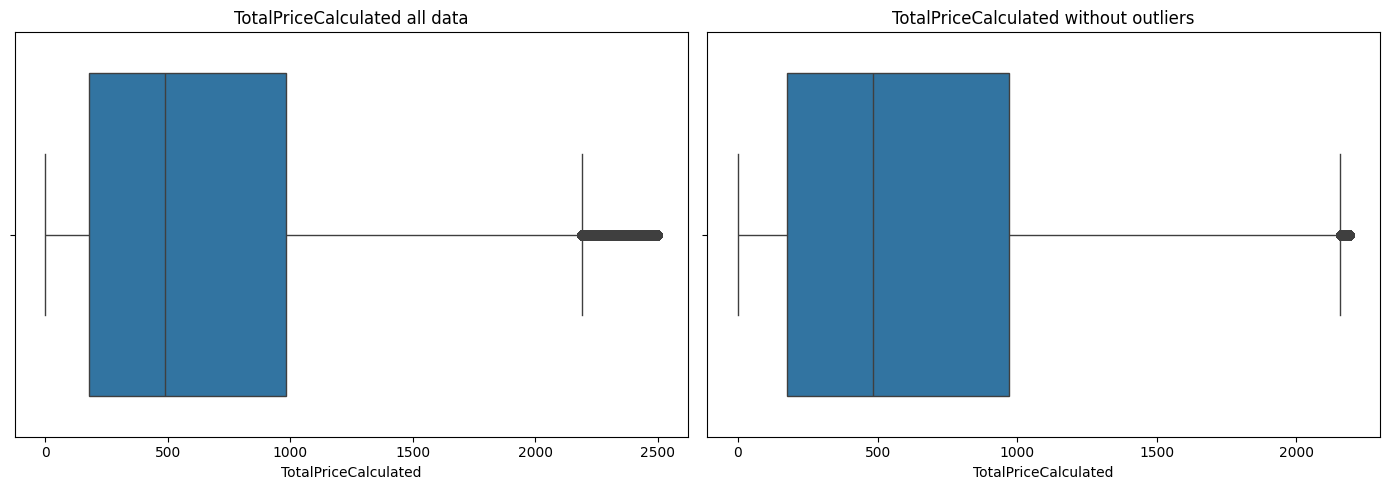

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df_sales_with_total_price_corrected, x='TotalPriceCalculated', ax=axes[0])
axes[0].set_title("TotalPriceCalculated all data")

df_no_outliers = df_sales_with_total_price_corrected[df_sales_with_total_price_corrected['IsOutlier'] == 0]
sns.boxplot(data=df_no_outliers, x='TotalPriceCalculated', ax=axes[1])
axes[1].set_title("TotalPriceCalculated without outliers")

plt.tight_layout()
plt.show()



In [78]:

print(f"A: {df_sales_with_total_price_corrected['TotalPriceCalculated'].size}")
print(f"B: {df_no_outliers['TotalPriceCalculated'].size}")
print(f"B: {df_sales_with_total_price_corrected['TotalPriceCalculated'].size - df_no_outliers['TotalPriceCalculated'].size}")


A: 6758125
B: 6709891
B: 48234


## 3 - Análisis de ventas 

### Enunciado

1. Identificar en qué **hora del día** se tienen más ventas.
2. Determinar si la empresa vende más durante los **días de semana** o durante el **fin de semana**.
---

### Detalles

#### Ventas por hora

- De la columna `SalesDate`, se obtine la hora (`Hour`) de cada venta.
- Despues se agrupan las ventas por hora, se calcula el total por hora y se determina la hora con mas ventas.

#### Semana vs. Fin de Semana

- Se clasifica cada venta según haya ocurrido un día de semana o no.
- Para ello, se utiliza el método `.dt.weekday`, donde:
  - `0` a `4` representan lunes a viernes --> IsWeekend = 0
  - `5` y `6` representan sábado y domingo (Fin de semana) --> IsWeekend = 1
- Se agrupan las ventas según corresponda y se cálcula el total vendido correspondiente.
- Se comparan los totales para determinar en qué tipo de días la empresa vende más.

---

### Resultado

- Se indica la **hora con mayor volumen de ventas**.
- Se presenta el **total vendido entre semana vs. fin de semana**.

---

In [68]:
df_sales_with_total_price_corrected['SalesDateAsDatetime'] = pd.to_datetime(df_sales_with_total_price_corrected['SalesDate'])
df_sales_with_total_price_corrected['Hour'] = df_sales_with_total_price_corrected['SalesDateAsDatetime'].dt.hour 

df_sales_with_total_price_corrected.head()

df_sales_per_hour = df_sales_with_total_price_corrected.groupby('Hour')['TotalPriceCalculated'].sum().reset_index()
df_sales_per_hour.head()


,Hour,TotalPriceCalculated
0,0.0,1.783134e+08
1,1.0,1.778232e+08
2,2.0,1.784208e+08
3,3.0,1.774438e+08
4,4.0,1.779327e+08


In [69]:
hour_with_max_sales = df_sales_per_hour.loc[df_sales_per_hour['TotalPriceCalculated'].idxmax(), :]
print(f"Hora: {hour_with_max_sales['Hour']} hs - Total vendido: ${hour_with_max_sales['TotalPriceCalculated']:,.2f}")


Hora: 16.0 hs - Total vendido: $179,014,421.24


In [70]:
df_sales_with_total_price_corrected['IsWeekend'] = (
    df_sales_with_total_price_corrected['SalesDateAsDatetime'].dt.weekday >= 5
).astype(int)

sales_week_vs_weekend = df_sales_with_total_price_corrected.groupby('IsWeekend')['TotalPriceCalculated'].sum().reset_index()
print(f"Ventas semana: ${sales_week_vs_weekend.loc[0,'TotalPriceCalculated']:,.2f}")
print(f"Ventas fin de semana: ${sales_week_vs_weekend.loc[1,'TotalPriceCalculated']:,.2f}")

Ventas semana: $3,123,404,728.48
Ventas fin de semana: $1,192,862,950.44


## 4 - Edad y experiencia de empleados

### Enunciado

1. Calcular la **edad del empleado al momento de su contratación**.
2. Calcular los **años de experiencia del empleado al momento de cada venta**.

---

### Detalles

#### Edad al ser contratado

- Se utilizan las columnas `BirthDate` y `HireDate`.
- A partir de la diferencia entre ambas fechas se calcula la edad del empleado al momento de ser contratado.

#### Años de experiencia al momento de la venta

- Se utilizan las columnas `HireDate` y `SalesDate`.
- Se calcula el tiempo entre la fecha de contratación y la fecha de cada venta.

---

### Resultado

- Se genera la columna `AgeAtHire`, que indica la edad del empleado cuando fue contratado.
- Se genera la columna `YearsExperience`, que indica los años de experiencia del empleado al momento de realizada cada venta.


In [71]:
df_employees['BirthDate'] = pd.to_datetime(df_employees['BirthDate'], errors='coerce')
df_employees['HireDate'] = pd.to_datetime(df_employees['HireDate'], errors='coerce')

df_sales_with_total_price_corrected =  df_sales_with_total_price_corrected.merge(df_employees[['EmployeeID', 'BirthDate', 'HireDate']], left_on='SalesPersonID', right_on='EmployeeID', how='left')
df_sales_with_total_price_corrected.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,Price,TotalPriceCalculated,IsOutlier,SalesDateAsDatetime,Hour,IsWeekend,EmployeeID,BirthDate,HireDate
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G,44.2337,309.63590,0,2018-02-05 07:38:25.430,7.0,0,6,1987-01-13,2013-06-22 13:20:18.080
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8,62.5460,437.82200,0,2018-02-02 16:03:31.150,16.0,0,16,1951-07-07,2017-02-10 11:21:26.650
2,3,13,94024,23,24,0.0,0.0,2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0,79.0184,1896.44160,0,2018-05-03 19:31:56.880,19.0,0,13,1963-04-18,2011-12-12 10:43:52.940
3,4,8,73966,176,19,0.2,0.0,2018-04-07 14:43:55.420,R3DR9MLD5NR76VO17ULE,81.3167,1236.01384,0,2018-04-07 14:43:55.420,14.0,1,8,1956-12-13,2014-10-14 23:12:53.420
4,5,10,32653,310,9,0.0,0.0,2018-02-12 15:37:03.940,4BGS0Z5OMAZ8NDAFHHP3,79.9780,719.80200,0,2018-02-12 15:37:03.940,15.0,0,10,1963-12-30,2012-07-23 15:02:12.640


In [72]:
df_sales_with_total_price_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758125 entries, 0 to 6758124
Data columns (total 18 columns):
 #   Column                Dtype         
---  ------                -----         
 0   SalesID               int64         
 1   SalesPersonID         int64         
 2   CustomerID            int64         
 3   ProductID             int64         
 4   Quantity              int64         
 5   Discount              float64       
 6   TotalPrice            float64       
 7   SalesDate             object        
 8   TransactionNumber     object        
 9   Price                 float64       
 10  TotalPriceCalculated  float64       
 11  IsOutlier             int64         
 12  SalesDateAsDatetime   datetime64[ns]
 13  Hour                  float64       
 14  IsWeekend             int64         
 15  EmployeeID            int64         
 16  BirthDate             datetime64[ns]
 17  HireDate              datetime64[ns]
dtypes: datetime64[ns](3), float64(5), int64(8)

In [73]:

df_sales_with_total_price_corrected['AgeAtHire'] = (
    (df_sales_with_total_price_corrected['HireDate'] - df_sales_with_total_price_corrected['BirthDate']).dt.days / 365
).round(1)


df_sales_with_total_price_corrected['ExperienceAtSale'] = (
    (df_sales_with_total_price_corrected['SalesDateAsDatetime'] - df_sales_with_total_price_corrected['HireDate']).dt.days / 365
).round(1)

df_sales_with_total_price_corrected.head()



,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,Price,TotalPriceCalculated,IsOutlier,SalesDateAsDatetime,Hour,IsWeekend,EmployeeID,BirthDate,HireDate,AgeAtHire,ExperienceAtSale
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G,44.2337,309.63590,0,2018-02-05 07:38:25.430,7.0,0,6,1987-01-13,2013-06-22 13:20:18.080,26.5,4.6
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8,62.5460,437.82200,0,2018-02-02 16:03:31.150,16.0,0,16,1951-07-07,2017-02-10 11:21:26.650,65.6,1.0
2,3,13,94024,23,24,0.0,0.0,2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0,79.0184,1896.44160,0,2018-05-03 19:31:56.880,19.0,0,13,1963-04-18,2011-12-12 10:43:52.940,48.7,6.4
3,4,8,73966,176,19,0.2,0.0,2018-04-07 14:43:55.420,R3DR9MLD5NR76VO17ULE,81.3167,1236.01384,0,2018-04-07 14:43:55.420,14.0,1,8,1956-12-13,2014-10-14 23:12:53.420,57.9,3.5
4,5,10,32653,310,9,0.0,0.0,2018-02-12 15:37:03.940,4BGS0Z5OMAZ8NDAFHHP3,79.9780,719.80200,0,2018-02-12 15:37:03.940,15.0,0,10,1963-12-30,2012-07-23 15:02:12.640,48.6,5.6
